In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import plotly.express as px
import statsmodels
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

DATA_PATH = '../data/'

In [2]:
diversity_school = pd.read_csv(DATA_PATH + 'diversity_school.csv')
historical_tuition = pd.read_csv(DATA_PATH + 'historical_tuition.csv')
salary_potential = pd.read_csv(DATA_PATH + 'salary_potential.csv')
tuition_cost = pd.read_csv(DATA_PATH + 'tuition_cost.csv')
tuition_income = pd.read_csv(DATA_PATH + 'tuition_income.csv')

tuition_income['income_lvl'] = tuition_income['income_lvl'].str.replace('_',',')


In [3]:
# merges salary_potential with tuition_cost based on name
merged = salary_potential.merge(tuition_cost, how='inner', on='name') 
 #sets the new DataFrame's ID to name
merged.set_index('name',inplace=True)

#drops unwanted columns
merged.drop(columns=['make_world_better_percent','state','early_career_pay',
                    'state_code','rank','degree_length','in_state_total',
                    'out_of_state_total'],inplace=True)

#reduces the categories from 3 to 2 (only 2 variables were for profit)
merged['type'] = merged['type'].replace('For Profit','Public') 

#fills na values by the mean
merged['room_and_board'].fillna(merged.room_and_board.mean(),inplace=True) 

#creates the target 
y = merged['mid_career_pay'] 

#creates the feature dataframe
X = merged.drop(columns=['mid_career_pay']) 

#randomly split the train test groups
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size = 0.2,
                                                     random_state=42) 


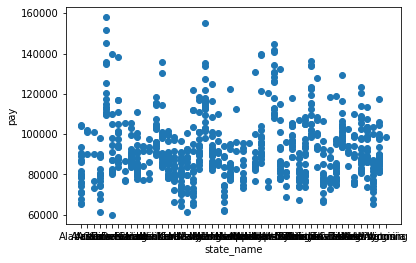

state_name


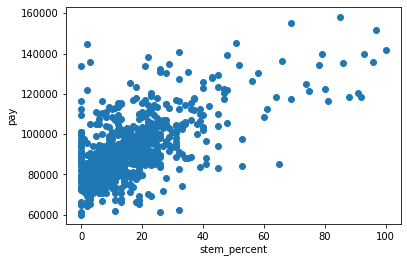

stem_percent


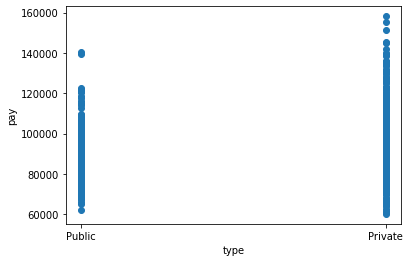

type


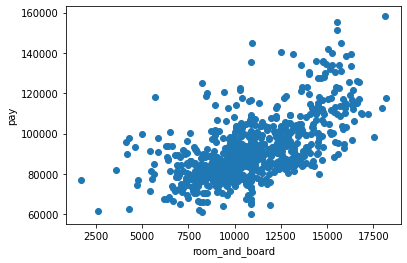

room_and_board


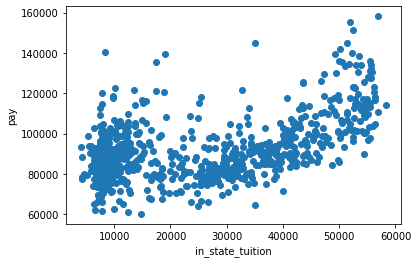

in_state_tuition


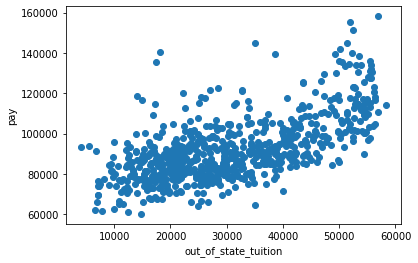

out_of_state_tuition


In [4]:
for  x in X.columns:
    plt.scatter(x=X[x],y=y)
    plt.xlabel(x)
    plt.ylabel('pay')
    plt.show()
    print(x)

The mean pay is:  92138.74


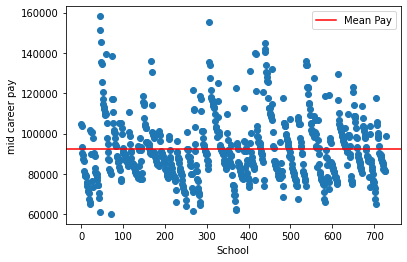

In [5]:
#Turns the Target mean into a vector
mean_vector = [y.mean()] * len(y)

#Plot the values for each target 
plt.plot(np.arange(len(y)),y,'o')

#Plot the baseline
plt.axhline(y=y.mean(),color='r',label='Mean Pay')


plt.xlabel('School')
plt.ylabel('mid career pay')
plt.legend()
print('The mean pay is: ',round(y.mean(),2))

In [6]:
#Initialize a Linear Regrssion model Then fitting the training data
model_LR = LinearRegression()
X_train_cont = X_train.select_dtypes(include=['float64','int64'])
model_LR.fit(X_train_cont,y_train)

#Predict the test data and calculate MAE
predicted = model_LR.predict(X_test.select_dtypes(include=['float64','int64']))
mean_error = mean_absolute_error(y_test, predicted)
print('The mean absolute error without Ordinal Encoder: ',round(mean_error,2))


The mean absolute error without Ordinal Encoder:  5932.65


In [7]:
print('The mean absolute error with Baseline and test data: ',round(mean_absolute_error(([y.median()] * len(y_test)),y_test),2))
print('The mean absolute error without One Hot Encoder: ',round(mean_error,2))

#Initialize a Linear Regression model with an Ordinal Encoder
model_oe = make_pipeline(OneHotEncoder(),LinearRegression())
model_oe.fit(X_train,y_train)

predicted = model_oe.predict(X_test)
mean_error_oe = mean_absolute_error(y_test, predicted)
print('The mean absolute error with One Hot Encoder: ',round(mean_error_oe,2))
mean_error_base = mean_absolute_error(([y.median()] * len(y_test)),predicted)
print('The mean absolute error with Baseline and predicted data: ',round(mean_error_base,2))

The mean absolute error with Baseline and test data:  10687.67
The mean absolute error without One Hot Encoder:  5932.65
The mean absolute error with One Hot Encoder:  5164.72
The mean absolute error with Baseline and predicted data:  10568.18


In [8]:
model_RF = make_pipeline(OneHotEncoder(),RandomForestRegressor(n_estimators = 70, random_state=42))
model_RF.fit(X_train,y_train)
predicted = model_RF.predict(X_test)
mean_error = mean_absolute_error(y_test, predicted)
print('The mean absolute error with a Random Forest Classifier: ', mean_error)

The mean absolute error with a Random Forest Classifier:  5658.043052837573


In [9]:
from sklearn import tree
dtr = make_pipeline(OneHotEncoder(),tree.DecisionTreeRegressor())
dtr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['state_name', 'type'])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [10]:
predicted = dtr.predict(X_test)
print('The mean absolute error with a Decision Tree Regressor: ', mean_absolute_error(y_test,dtr.predict(X_test)))

The mean absolute error with a Decision Tree Regressor:  7841.095890410959


In [11]:
model = make_pipeline( OneHotEncoder(),Ridge(normalize=True, alpha=0.05) )
model.fit(X_train,y_train)
mean_error = mean_absolute_error(y_test, model.predict(X_test))
print(mean_error)

5160.80262029003


In [12]:

from xgboost import XGBRegressor
oe = OrdinalEncoder()
X_T = oe.fit_transform(X_train)
model_xgr = XGBRegressor(random_state=42, n_jobs=10)

model_xgr.fit(X_T,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
print('Ridge regression MAE is ', round(mean_absolute_error(y_test, model.predict(X_test)),2))
print('Gradient Boosting MAE is', round(mean_absolute_error(y_test, model_xgr.predict(oe.transform(X_test))),2))
print('Decision Tree Regressor MAE is', round(mean_absolute_error(y_test, dtr.predict(X_test)),2))
print('Random Forest Regressor MAE is', round(mean_absolute_error(y_test, model_RF.predict(X_test)),2))

Ridge regression MAE is  5160.8
Gradient Boosting MAE is 6116.42
Decision Tree Regressor MAE is 7841.1
Random Forest Regressor MAE is 5658.04


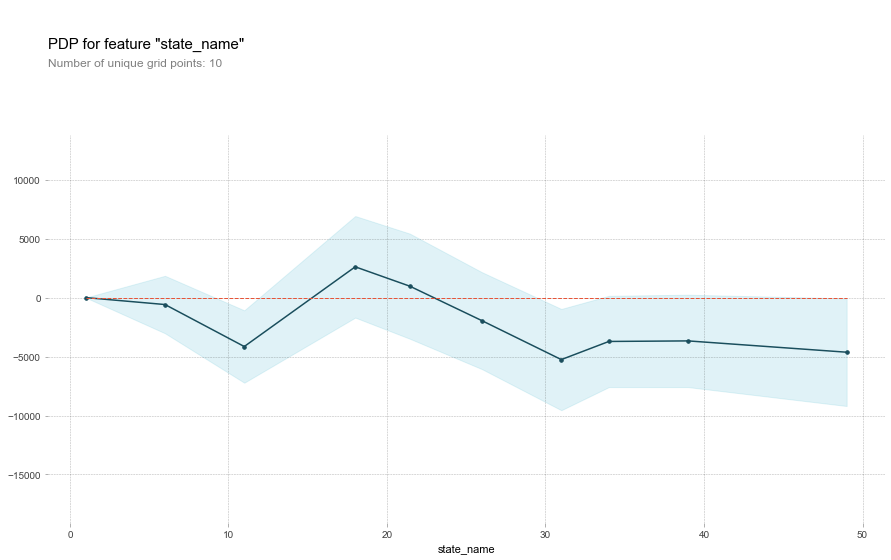

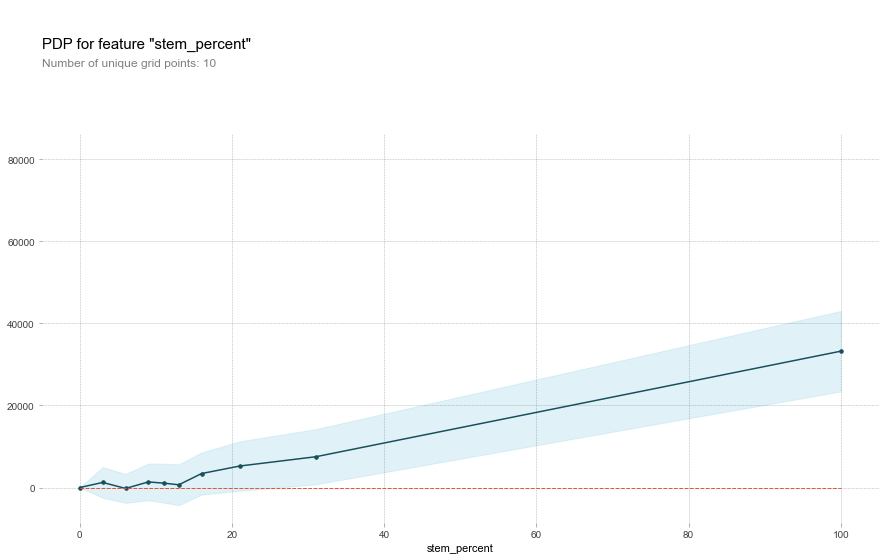

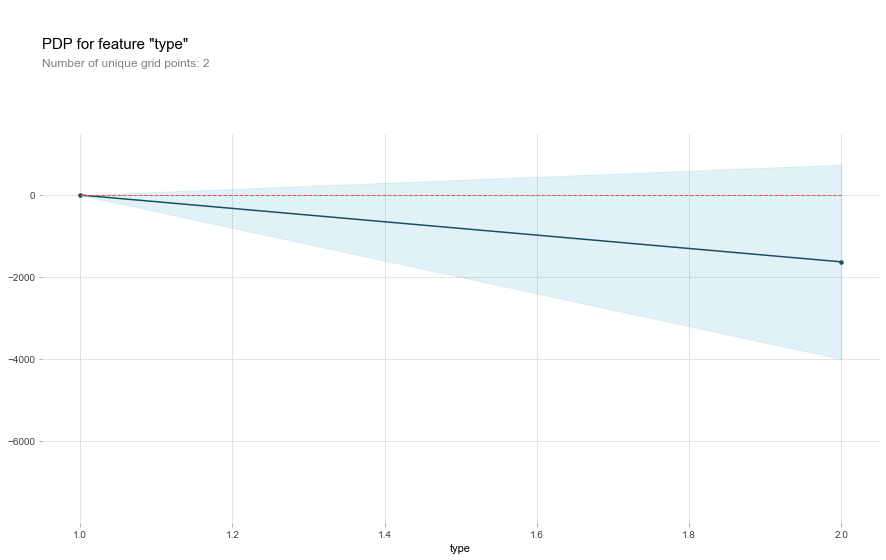

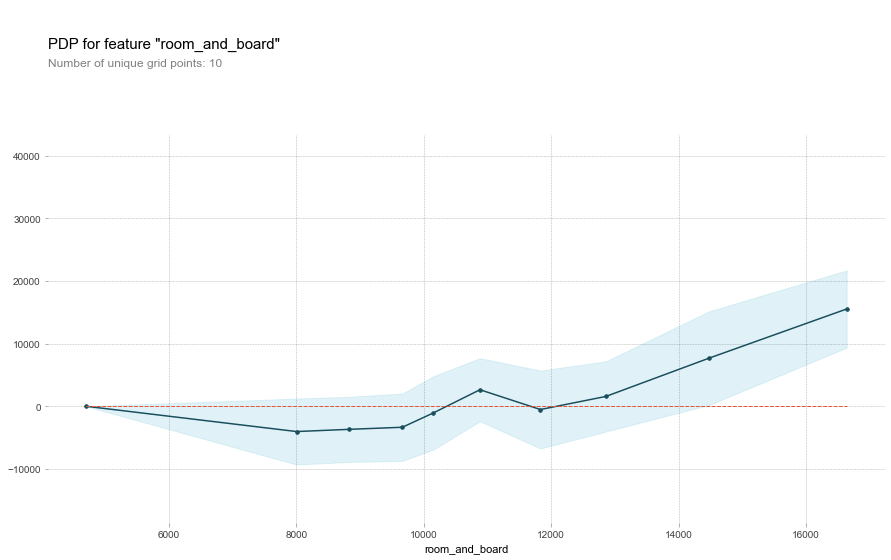

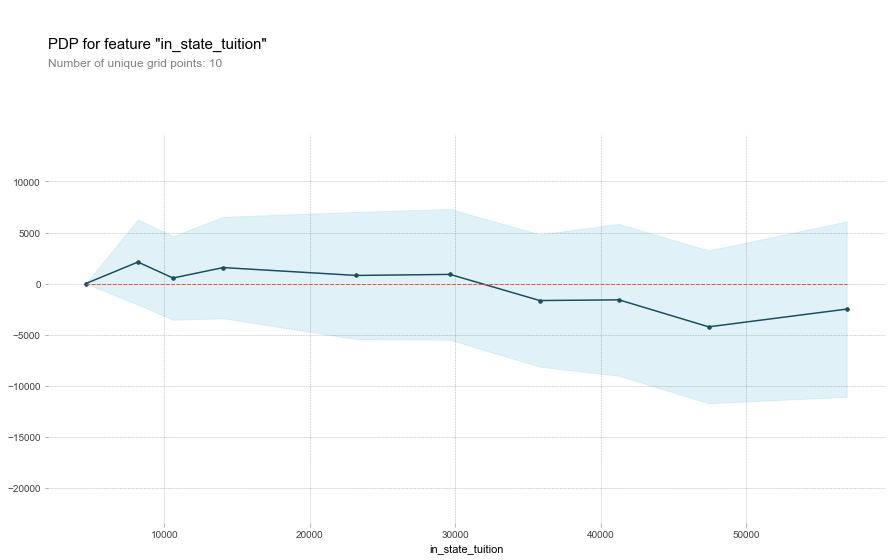

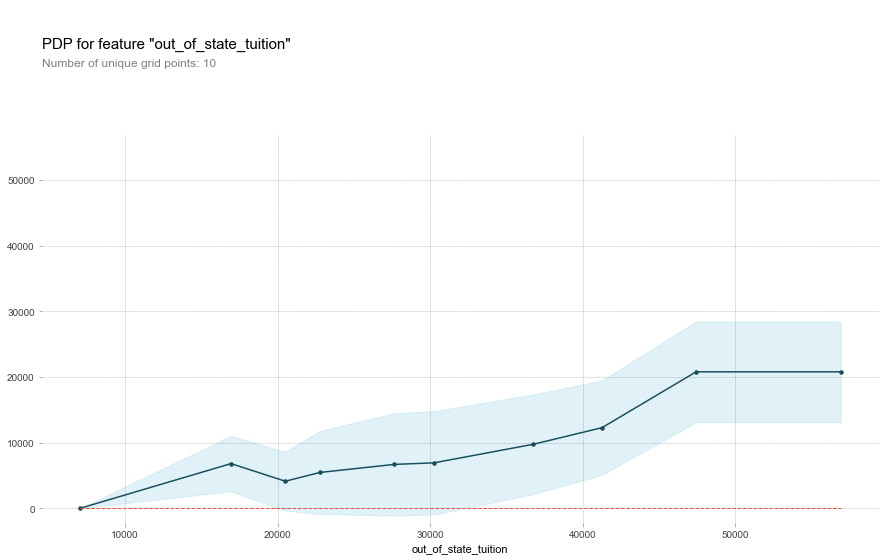

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'stem_percent'


for x in X_test.columns:
    isolate = pdp_isolate(
          model=model_xgr,
          dataset=oe.transform(X_test),
          model_features=X_test.columns,
          feature=x
    )
    pdp_plot(isolate, feature_name=x)